In [48]:
!pip install -U spacy

# download english vocab
!python -m spacy download en_core_web_sm

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.2)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Introduction 

This kernel has been made to study 4 things :

* compare the precision of Doc2Vec vs TF-IDF 

* Determine if stemming have an impact on performance of the model. If it's improve the scores or decrease the score. We know that stemming is used to reduce the size of the vocabulary to speed the training. But if it's reduce  the vocabulary  and in the same time reduce the accuracy we need to know at what level. 

* Determine the size of the dataset. Size from which our model provided good results. How many words? The size of the vocabulary.

* What is the best simple models that perform good on big and tiny dataset.

In [0]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

The aim of this project is to study the performance of TF-IDF VS Doc2Vec. 
We are going to use 4 modèles to compare them :

* LinearSVC 
* XGboost 
* Logistic-regression 
* Naives-bayes

In [0]:
import pandas as pd 
import numpy as np 
import seaborn  as sns 
import matplotlib.pyplot as plt 

In [51]:
newsgroups_train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

# Study the dataset 

## Classes

## Distrubution 

In [0]:
def displayFeaturesAndDescribe(array_features, feature, kind='bar', color=None):
    s = pd.Series(array_features)
    feature_count = (s.value_counts() /s.shape[0]) * 100
    feature_dataframe = pd.DataFrame()
    feature_dataframe[feature] = feature_count.index
    feature_dataframe['Percentage'] = feature_count.values
    sns.catplot(x=feature, y='Percentage', kind=kind, data=feature_dataframe, hue='Percentage', aspect=2, height=5,legend_out=True)
    

In [53]:
target_df = pd.DataFrame({'target_name' : newsgroups_train.target_names,  'target_value' :np.unique(newsgroups_train.target)})
target_df 

,target_name,target_value
0,alt.atheism,0
1,comp.graphics,1
2,comp.os.ms-windows.misc,2
3,comp.sys.ibm.pc.hardware,3
4,comp.sys.mac.hardware,4
5,comp.windows.x,5
6,misc.forsale,6
7,rec.autos,7
8,rec.motorcycles,8
9,rec.sport.baseball,9


In [54]:
target_serie = pd.Series(newsgroups_train.target)
target_df['distribution'] = target_serie.value_counts()/target_serie.count() * 100
target_df

,target_name,target_value,distribution
0,alt.atheism,0,4.242531
1,comp.graphics,1,5.161747
2,comp.os.ms-windows.misc,2,5.223617
3,comp.sys.ibm.pc.hardware,3,5.214778
4,comp.sys.mac.hardware,4,5.108715
5,comp.windows.x,5,5.241294
6,misc.forsale,6,5.170585
7,rec.autos,7,5.250133
8,rec.motorcycles,8,5.285487
9,rec.sport.baseball,9,5.276648


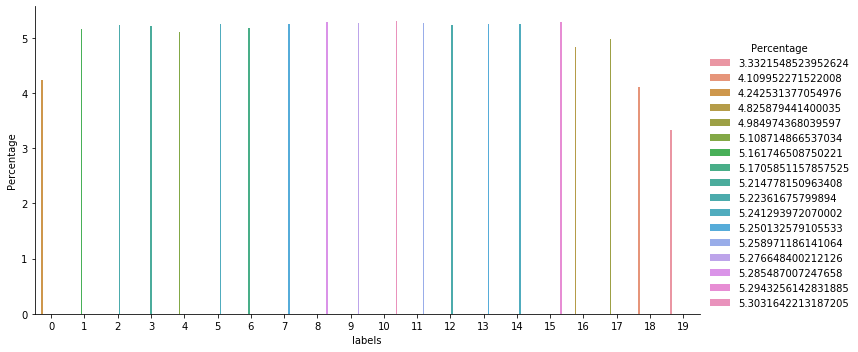

In [55]:
displayFeaturesAndDescribe(array_features=newsgroups_train.target, feature='labels')

In [56]:
target_df['distribution'].describe()

count    20.000000
mean      5.000000
std       0.514865
min       3.332155
25%       5.077780
50%       5.223617
75%       5.252342
max       5.303164
Name: distribution, dtype: float64

The dataset is well balanced. The percentage of each class is approximatly of 5%. Religion is represented at 3.3%.

# Clean the data 

The first step we are going to use spacy to clean the data by :

* lower all the word to avoid that word like : Hello HELLO or hello are 
considered as 3 differents words.
* removing stop words 
* removing punctuation 
* lemming 


Note : In the second part we will do the same without lemming to see the performance.

In [57]:
import spacy

print('spaCy Version: %s' % (spacy.__version__))
spacy_nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.STOP_WORDS
punctuations = spacy.lang.punctuation.PUNCT

spaCy Version: 2.2.2


In [0]:
parse = spacy_nlp(newsgroups_train.data[0])

In [59]:
parse.vocab.length

572

Spacy parser, parse the text and apply different model on the text :

* Tokenizer : Split the text in token. (base on the language)
* NER => identify entity in the text 
* Tagger => Assign part-of-speech tags.
* TextCat => optionnal you can add a text classifier 

In [0]:
# create a copy of the dataset 
x_train = newsgroups_train.data.copy()

In [0]:

def prepareText(text):
  """
  This function clean the text. 
  """

  processing = spacy_nlp(text)
  
  # lowering words and lemming 
  # strip space 
  # don't apply lemming if the word is a pronoun because spacy convert the word in "-PRON-" and we need all the word 
  processing = [ word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in processing ] 

  # remove stop words and punctuation 

  processing = [word  for word in processing if (word not in stop_words and punctuations)]

  return processing  

We will implement the same function but without lemming. We could add a boolean variable to indicate if we do lemming or not but for performance reason I prefer to implement an other function.

Let's test this one 

In [62]:
prepareText(x_train[0])

[':',
 'lerxst@wam.umd.edu',
 '(',
 'thing',
 ')',
 '\n',
 'subject',
 ':',
 'car',
 '!',
 '?',
 '\n',
 'nntp',
 '-',
 'posting',
 '-',
 'host',
 ':',
 'rac3.wam.umd.edu',
 '\n',
 'organization',
 ':',
 'university',
 'maryland',
 ',',
 'college',
 'park',
 '\n',
 'line',
 ':',
 '15',
 '\n\n ',
 'wonder',
 'enlighten',
 'car',
 '\n',
 'day',
 '.',
 '2-door',
 'sport',
 'car',
 ',',
 'look',
 'late',
 '60s/',
 '\n',
 'early',
 '70',
 '.',
 'bricklin',
 '.',
 'door',
 'small',
 '.',
 'addition',
 ',',
 '\n',
 'bumper',
 'separate',
 'rest',
 'body',
 '.',
 '\n',
 'know',
 '.',
 'tellme',
 'model',
 ',',
 'engine',
 'spec',
 ',',
 'year',
 '\n',
 'production',
 ',',
 'car',
 ',',
 'history',
 ',',
 'info',
 '\n',
 'funky',
 'look',
 'car',
 ',',
 'e',
 '-',
 'mail',
 '.',
 '\n\n',
 'thank',
 ',',
 '\n',
 '-',
 'il',
 '\n   ',
 '----',
 'bring',
 'neighborhood',
 'lerxst',
 '----',
 '\n\n\n\n\n']

In [63]:

for i in range(0, len(x_train)) :
  x_train[i] = prepareText(x_train[i])

x_train[0]

[':',
 'lerxst@wam.umd.edu',
 '(',
 'thing',
 ')',
 '\n',
 'subject',
 ':',
 'car',
 '!',
 '?',
 '\n',
 'nntp',
 '-',
 'posting',
 '-',
 'host',
 ':',
 'rac3.wam.umd.edu',
 '\n',
 'organization',
 ':',
 'university',
 'maryland',
 ',',
 'college',
 'park',
 '\n',
 'line',
 ':',
 '15',
 '\n\n ',
 'wonder',
 'enlighten',
 'car',
 '\n',
 'day',
 '.',
 '2-door',
 'sport',
 'car',
 ',',
 'look',
 'late',
 '60s/',
 '\n',
 'early',
 '70',
 '.',
 'bricklin',
 '.',
 'door',
 'small',
 '.',
 'addition',
 ',',
 '\n',
 'bumper',
 'separate',
 'rest',
 'body',
 '.',
 '\n',
 'know',
 '.',
 'tellme',
 'model',
 ',',
 'engine',
 'spec',
 ',',
 'year',
 '\n',
 'production',
 ',',
 'car',
 ',',
 'history',
 ',',
 'info',
 '\n',
 'funky',
 'look',
 'car',
 ',',
 'e',
 '-',
 'mail',
 '.',
 '\n\n',
 'thank',
 ',',
 '\n',
 '-',
 'il',
 '\n   ',
 '----',
 'bring',
 'neighborhood',
 'lerxst',
 '----',
 '\n\n\n\n\n']

# TF-IDF 

Once our training data have been cleaned we need to apply countVectorizer to the dataset. 

CountVectorizer will tranform each ext to a sparse matrix that represent words frequency in the text. Then we will be able to apply TF-IDF on this sparse matrix. 

Tf_IDF : this algorithm use word frequency in a document and the word frequency in other document to compute a value that represent the word in the document. The more a word appear the least this value will be high. 
It's determine the more relevant word in a text. The important word. 

The intuition is that word that are important are not repeated frequently in a document.

## CountVectorizer 

Here by doing ‘count_vect.fit_transform(twenty_train.data)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix. [n_samples, n_features].

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vec = CountVectorizer()
cv_data = count_vec.fit_transform(newsgroups_train.data)
tfidf = TfidfTransformer()
tfidf_data = tfidf.fit_transform(cv_data)

In [65]:
tfidf_data.shape

(11314, 130107)

In [66]:
newsgroups_train.target.shape

(11314,)

In [0]:
import numpy as np 
classes = np.unique(newsgroups_train.target)

The different class name in the dataset are :

In [68]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Each row represent a document of dataset.

#training 

We can now train our 4 modeles on the TF-IDF matrix now that we have a representation of all the document. We need to train our modele to predict a input text class base using the TF-IDF matrix. 


We are going to create a pipeline for each one :

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
import seaborn as sns 



In [0]:
from sklearn.pipeline import Pipeline

naives_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
log_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression())])
sgd_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier())]) 
svc_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC())])



### classification_report : 

Compute precision, recall, F-measure and support for each class

* The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

* The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

* precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

* The support is the number of occurrences of each class in y_true.

In [71]:
from sklearn.metrics import classification_report
modeles = {"naives":naives_clf, "logistic regression": log_clf, "SGD_classifier":sgd_clf, "Linear SVC":svc_clf}


for key in modeles:
  modeles[key].fit(newsgroups_train.data, newsgroups_train.target)
  predicted = modeles[key].predict(newsgroups_test.data)
  score = classification_report(y_pred=predicted, y_true=newsgroups_test.target, labels=classes)
  print(f"Modele : {key} score : {score} \n\n\n")

Modele : naives score :               precision    recall  f1-score   support

           0       0.80      0.52      0.63       319
           1       0.81      0.65      0.72       389
           2       0.82      0.65      0.73       394
           3       0.67      0.78      0.72       392
           4       0.86      0.77      0.81       385
           5       0.89      0.75      0.82       395
           6       0.93      0.69      0.80       390
           7       0.85      0.92      0.88       396
           8       0.94      0.93      0.93       398
           9       0.92      0.90      0.91       397
          10       0.89      0.97      0.93       399
          11       0.59      0.97      0.74       396
          12       0.84      0.60      0.70       393
          13       0.92      0.74      0.82       396
          14       0.84      0.89      0.87       394
          15       0.44      0.98      0.61       398
          16       0.64      0.94      0.76       364
   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Modele : logistic regression score :               precision    recall  f1-score   support

           0       0.80      0.74      0.77       319
           1       0.69      0.78      0.74       389
           2       0.76      0.75      0.75       394
           3       0.73      0.72      0.72       392
           4       0.81      0.83      0.82       385
           5       0.83      0.74      0.78       395
           6       0.76      0.90      0.83       390
           7       0.91      0.89      0.90       396
           8       0.94      0.95      0.94       398
           9       0.87      0.93      0.90       397
          10       0.94      0.96      0.95       399
          11       0.93      0.89      0.91       396
          12       0.76      0.78      0.77       393
          13       0.89      0.84      0.86       396
          14       0.89      0.92      0.91       394
          15       0.79      0.93      0.85       398
          16       0.71      0.90      0.80 

F1-score and Precision

In [0]:
naives_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
log_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression())])
sgd_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier())]) 
svc_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC())])

In [73]:
from sklearn.metrics import classification_report
modeles = {"naives":naives_clf, "logistic regression": log_clf, "SGD_classifier":sgd_clf, "Linear SVC":svc_clf}


for key in modeles:
  modeles[key].fit(newsgroups_train.data, newsgroups_train.target)
  predicted = modeles[key].predict(newsgroups_test.data)
  score = classification_report(y_pred=predicted, y_true=newsgroups_test.target, labels=classes)
  print(f"Modele : {key} score : {score} \n\n\n")

Modele : naives score :               precision    recall  f1-score   support

           0       0.80      0.69      0.74       319
           1       0.78      0.72      0.75       389
           2       0.79      0.72      0.75       394
           3       0.68      0.81      0.74       392
           4       0.86      0.81      0.84       385
           5       0.87      0.78      0.82       395
           6       0.87      0.80      0.83       390
           7       0.88      0.91      0.90       396
           8       0.93      0.96      0.95       398
           9       0.91      0.92      0.92       397
          10       0.88      0.98      0.93       399
          11       0.75      0.96      0.84       396
          12       0.84      0.65      0.74       393
          13       0.92      0.79      0.85       396
          14       0.82      0.94      0.88       394
          15       0.62      0.96      0.76       398
          16       0.66      0.95      0.78       364
   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Modele : logistic regression score :               precision    recall  f1-score   support

           0       0.78      0.72      0.75       319
           1       0.71      0.79      0.75       389
           2       0.75      0.76      0.75       394
           3       0.71      0.71      0.71       392
           4       0.80      0.82      0.81       385
           5       0.84      0.75      0.79       395
           6       0.78      0.87      0.82       390
           7       0.90      0.89      0.89       396
           8       0.93      0.95      0.94       398
           9       0.88      0.92      0.90       397
          10       0.93      0.96      0.94       399
          11       0.95      0.91      0.93       396
          12       0.74      0.78      0.76       393
          13       0.88      0.86      0.87       396
          14       0.88      0.91      0.90       394
          15       0.80      0.93      0.86       398
          16       0.74      0.90      0.81 

### With Stemming 

We herit from CountVectorizer and we apply stemming to each words in the 
text. We use NLTK for the stemming with the english vocab.


In [74]:
!pip install nltk

In [75]:
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
naives_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
log_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression())])
sgd_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier())]) 
svc_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC())])

In [77]:
from sklearn.metrics import classification_report
modeles = {"naives":naives_clf, "logistic regression": log_clf, "SGD_classifier":sgd_clf, "Linear SVC":svc_clf}


for key in modeles:
  modeles[key].fit(newsgroups_train.data, newsgroups_train.target)
  predicted = modeles[key].predict(newsgroups_test.data)
  score = classification_report(y_pred=predicted, y_true=newsgroups_test.target, labels=classes)
  print(f"Modele : {key} score : {score} \n\n\n")

Modele : naives score :               precision    recall  f1-score   support

           0       0.81      0.66      0.73       319
           1       0.78      0.72      0.75       389
           2       0.82      0.69      0.75       394
           3       0.69      0.80      0.74       392
           4       0.86      0.82      0.84       385
           5       0.86      0.79      0.83       395
           6       0.88      0.75      0.81       390
           7       0.87      0.93      0.90       396
           8       0.92      0.96      0.94       398
           9       0.93      0.92      0.92       397
          10       0.90      0.98      0.94       399
          11       0.71      0.97      0.82       396
          12       0.83      0.66      0.73       393
          13       0.92      0.79      0.85       396
          14       0.82      0.94      0.88       394
          15       0.60      0.97      0.74       398
          16       0.65      0.94      0.77       364
   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Modele : logistic regression score :               precision    recall  f1-score   support

           0       0.77      0.71      0.74       319
           1       0.72      0.80      0.76       389
           2       0.76      0.76      0.76       394
           3       0.72      0.73      0.73       392
           4       0.80      0.84      0.82       385
           5       0.84      0.77      0.81       395
           6       0.75      0.85      0.80       390
           7       0.91      0.88      0.90       396
           8       0.97      0.95      0.96       398
           9       0.91      0.92      0.92       397
          10       0.93      0.97      0.95       399
          11       0.94      0.92      0.93       396
          12       0.75      0.78      0.77       393
          13       0.88      0.86      0.87       396
          14       0.88      0.93      0.90       394
          15       0.80      0.91      0.85       398
          16       0.73      0.90      0.81 

## Results

If we compare the scores in the three cases :

* The lemming don't have a big impact on the scores. We don't have a big improvement in performance.
* Removing the stops words and the punctuations improve

* classes that have lower score have most of the time lower support value 
have lower scores. This can been explained by the fact that the algortihm can train on less example of this classe so he learn less pattern to recognize this classe compare to others. Notice that when we study the dataset distribution we see that topic 19 (religion 3.3%), 0 (atheism) and 18 (politics ) was the classe with less data. And we see that on this class the model have lower performance compare to other classes where the data quantity is close to the mean (5%).

### Ideas
[Handle imbalanced dataset](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

Resampling Techniques — Oversample minority class

Note : we need to do train_test_split before. 
Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.



# Doc2Vec performance


Now we are going to implement Doc2Vec on the same dataset.

In [78]:
!pip install gensim 

We are going to use gensim Doc2Vec. 

Doc2Vec technique is use to get a representation of a document words. 
A Document vector represent the text. 

We have already clean and tokenize the text with the prepareText function. 
Now we need to create a list of TaggedDocument.


In [0]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec


# create a tagged object 

taggedDocument = [TaggedDocument(doc, [tag]) for doc, tag in zip(x_train, newsgroups_train.target)]


Note : TaggedDocument() take a string as document and a list of tag 
so : 
  * doc : String 
  * tag : [list of tag]

In [80]:
taggedDocument[0].tags

[7]

In [81]:
taggedDocument[0].words[1:10]

['lerxst@wam.umd.edu', '(', 'thing', ')', '\n', 'subject', ':', 'car', '!']

* If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
* vector_size : 300- dimensional feature vectors. (In the research paper they use 400) 

* window (int, optional) – The maximum distance between the current and predicted word within a sentence.

* min_count=2, ignores all words with total frequency lower than this.
* negative=5 , specifies how many “noise words” should be drawn.
* hs=0 , and negative is non-zero, negative sampling will be used.
* sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
* workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [0]:
import multiprocessing
cores = multiprocessing.cpu_count()

doc2vec = Doc2Vec(dm=1, vector_size=400, window=20, min_count=2, negative=5, hs=0, sample=0, workers=cores)



Build a vocab from all the documents.

In [0]:
doc2vec.build_vocab(taggedDocument)

In [0]:
from tqdm import tqdm

doc2vec.train(taggedDocument, total_examples=len(taggedDocument), epochs=10)

### Vec_for_learning :

The inference tries to fit a later example into a frozen model, and so if you re-present the same document, it should 
wind up 'close' to the vector that the same document induced in multi-pass bulk training. But how 'close' would depend 
on a lot of things. The information in the PV paper about parameter choices is limited.


In [0]:

def vec_for_learning(doc2vec_model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in tqdm(tagged_docs)])
    return targets, regressors

 targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])

 At this line we use Zip to iter on an array of tuple that contains the tag associated to the i document and the Document vector that represent the i ème document. 

targets : contains the tags 
regressors : contains all the vector infered associated to a document.

demonstration :

array = [(1, 'a'), (2, 'b'), (3, 'c')]

target, reg = zip(*array)

print(target, reg)

==> output :
(1, 2, 3) ('a', 'b', 'c') 

Test have not been prepared. So we need to do the same operation that on the training data on the test data.

In [86]:

test_data = newsgroups_test.data.copy()

for i in range(0, len(test_data)) :
  test_data[i] = prepareText(test_data[i])

test_data[0]

[':',
 'v064mb9k@ubvmsd.cc.buffalo.edu',
 '(',
 'neil',
 'b.',
 'gandler',
 ')',
 '\n',
 'subject',
 ':',
 'need',
 'info',
 '88',
 '-',
 '89',
 'bonneville',
 '\n',
 'organization',
 ':',
 'university',
 'buffalo',
 '\n',
 'line',
 ':',
 '10',
 '\n',
 'news',
 '-',
 'software',
 ':',
 'vax',
 '/',
 'vms',
 'vnews',
 '1.41',
 '\n',
 'nntp',
 '-',
 'posting',
 '-',
 'host',
 ':',
 'ubvmsd.cc.buffalo.edu',
 '\n\n\n ',
 'little',
 'confused',
 'model',
 '88',
 '-',
 '89',
 'bonneville',
 '.',
 '\n',
 'hear',
 'le',
 'se',
 'lse',
 'sse',
 'ssei',
 '.',
 'tell',
 '\n',
 'difference',
 'far',
 'feature',
 'performance',
 '.',
 'curious',
 '\n',
 'know',
 'book',
 'value',
 'prefereably',
 '89',
 'model',
 '.',
 '\n',
 'book',
 'value',
 'usually',
 '.',
 'word',
 '\n',
 'demand',
 'time',
 'year',
 '.',
 'hear',
 'mid',
 '-',
 'spring',
 '\n',
 'early',
 'summer',
 'good',
 'time',
 'buy',
 '.',
 '\n\n\t\t\t',
 'neil',
 'gandler',
 '\n']

In [0]:
taggedTestDocument = [TaggedDocument(doc, [tag]) for doc, tag in zip(test_data, newsgroups_test.target)]

# Training & Testing

We remove Naives bayes because we can not use it on negative input. And the Doc2Vec contains negative values.

In [0]:
from sklearn.metrics import classification_report 
modeles = {"logistic regression": LogisticRegression(), "SGD_classifier": SGDClassifier(), "Linear SVC": LinearSVC()}

In [89]:
y_train, x_train = vec_for_learning(doc2vec, taggedDocument)
y_test, x_test = vec_for_learning(doc2vec, taggedTestDocument)


100%|██████████| 7532/7532 [03:40<00:00, 34.16it/s]


In [90]:
#testing 
for key in tqdm(modeles):
  modeles[key].fit(x_train, y_train)  
  
  predicted = modeles[key].predict(x_test)
  
  # F1-Score & Recall & Precision 
  score = classification_report(predicted, y_test, labels=classes)
  
  print(f"Modele : {key} score : {score}")

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
 33%|███▎      | 1/3 [01:04<02:08, 64.26s/it]

Modele : logistic regression score :               precision    recall  f1-score   support

           0       0.72      0.66      0.69       346
           1       0.67      0.66      0.67       395
           2       0.57      0.62      0.59       359
           3       0.67      0.61      0.64       429
           4       0.78      0.80      0.79       374
           5       0.74      0.76      0.75       386
           6       0.68      0.58      0.63       458
           7       0.85      0.83      0.84       405
           8       0.92      0.92      0.92       400
           9       0.92      0.88      0.90       416
          10       0.92      0.92      0.92       402
          11       0.87      0.83      0.85       415
          12       0.65      0.71      0.68       362
          13       0.76      0.83      0.80       362
          14       0.85      0.86      0.85       390
          15       0.85      0.76      0.80       447
          16       0.79      0.72      0.75 

 67%|██████▋   | 2/3 [01:12<00:47, 47.45s/it]

Modele : SGD_classifier score :               precision    recall  f1-score   support

           0       0.55      0.80      0.65       219
           1       0.70      0.49      0.58       561
           2       0.51      0.59      0.54       340
           3       0.51      0.70      0.59       286
           4       0.75      0.77      0.76       377
           5       0.75      0.65      0.69       457
           6       0.47      0.79      0.59       233
           7       0.82      0.75      0.79       432
           8       0.95      0.76      0.84       497
           9       0.84      0.91      0.87       369
          10       0.93      0.80      0.86       463
          11       0.85      0.82      0.84       411
          12       0.58      0.70      0.63       322
          13       0.76      0.78      0.77       387
          14       0.86      0.78      0.82       433
          15       0.78      0.84      0.81       370
          16       0.78      0.65      0.71      

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 3/3 [01:42<00:00, 42.31s/it]

Modele : Linear SVC score :               precision    recall  f1-score   support

           0       0.69      0.64      0.67       343
           1       0.64      0.68      0.66       365
           2       0.55      0.60      0.58       360
           3       0.64      0.57      0.60       438
           4       0.78      0.78      0.78       389
           5       0.73      0.75      0.74       384
           6       0.67      0.59      0.63       444
           7       0.83      0.82      0.83       399
           8       0.92      0.88      0.90       418
           9       0.90      0.86      0.88       417
          10       0.93      0.89      0.91       414
          11       0.86      0.82      0.84       419
          12       0.63      0.69      0.66       357
          13       0.76      0.83      0.79       365
          14       0.85      0.84      0.84       396
          15       0.83      0.76      0.80       436
          16       0.78      0.69      0.73       409

# TF-IDF vs Doc2Vec 




# Idea

* Use grid search to search better hyper parameter.
* increase the window size for the Doc2Vec.
* reduce the vector_size to reduce overfitting.

# Size from which our model provided good results

test on 4 size :

* 1 millions words 
* 500k words 
* 100k words 
* 1k words 

The first step is to construct a function that count the number of words and create a subdataset.

In [103]:
for i in range(10):
  rand = randrange(0, 1000)
  print(rand)

82
172
134
600
952
326
362
425
12
346


In [105]:
from random import randrange

# we can take all the data and make a array of size 20 that contains Dataset by classe 
df = pd.DataFrame({'Text' : newsgroups_train.data, 'target' : newsgroups_train.target})
df.head()

,Text,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [0]:



def countWordAndCreateDataset(datas, tags, nwords=100000):
  dataset = [ ]
  dataset_tag = []
  word_counter = 0
  while word_counter <= nwords:
    for target in range(0, len(newsgroups_train.target_names) -1):
      data = df[df['target'] == target]
      randindex = randrange(0, len(data))
      dataset.append(datas[randindex])
      dataset_tag.append(tags[target])
      word_counter += len(datas[randindex].split(' '))
  print(f"Return a dataset of that contains {word_counter} words")
  return (dataset, dataset_tag)
  
  

This selection function must create a balanced dataset.

In [107]:
sizes = [10000000, 5000000, 1000000, 600000, 500000, 10000, 5000]
dataset_dict = {}
for size in sizes:
  dataset_target_tuple = countWordAndCreateDataset(datas=newsgroups_train.data, tags=newsgroups_train.target, nwords=size)
  dataset_dict[size] = dataset_target_tuple

Return a dataset of that contains 10001390 words
Return a dataset of that contains 5003730 words
Return a dataset of that contains 1005048 words
Return a dataset of that contains 602152 words
Return a dataset of that contains 503654 words
Return a dataset of that contains 12423 words
Return a dataset of that contains 6345 words


In [108]:
len(dataset_dict[1000000][0])

3553

We have now 7 datasets of differents size that are well balanced. We are going to look at wich number of words in the corpus the dataset perform well.

contains our 7 datasets of differents size. Let's  clean those dataset and train TFIDF+ML_modele on them.

In [0]:
from sklearn.metrics import precision_recall_fscore_support

# We need to train different model for each dataset 
modeles_dict = {}
for key in dataset_dict:
  modeles_dict[key] =  {"naives":naives_clf, "logistic regression": log_clf, "SGD_classifier":sgd_clf, "Linear SVC":svc_clf} 



In [0]:

for dataset_key in dataset_dict:
  print(f"Dataset of size : {dataset_key} \n\n")
  modeles = modeles_dict[dataset_key]
  for key in modeles:
    modeles[key].fit(dataset_dict[dataset_key][0], dataset_dict[dataset_key][1])
    predicted = modeles[key].predict(newsgroups_test.data)
    score = precision_recall_fscore_support(newsgroups_test.target, predicted, average='weighted')
    print(f"Modele : {key} score : {score} \n\n\n")

Dataset of size : 10000000 




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Modele : naives score : (0.009995144526211973, 0.05111524163568773, 0.005239470962763271, None) 





/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Modele : logistic regression score : (0.002615893663397551, 0.05111524163568773, 0.004977078409140055, None) 





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Modele : SGD_classifier score : (0.03543332023909441, 0.05616038236856081, 0.029820277692959234, None) 





do the same operation with Doc2Vec 

In [95]:
def prepareDataset(dataset):
  for i in tqdm(range(0, len(dataset)-1)):
    dataset[i] = prepareText(dataset[i])
    
for key in dataset_dict:
  prepareDataset(dataset=dataset_dict[key][0])

100%|██████████| 17/17 [00:01<00:00, 14.42it/s]


# Doc2Vec similarity

We are going to use Doc2Vec similarity method to find similar document. 

* We can use a a word embedding to find similar Document Vector to a word.

exp : word = Sport 
    - If we ask all the Document similar to "Sport" normaly we should get all the Document vector close to "Sport".